In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_compressed_sensing import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_sensor_per_node'] = 13
problem_spec['n_node'] = 6
problem_spec['n_sensor'] = problem_spec['n_sensor_per_node'] * problem_spec['n_node']
problem_spec['vector_size'] = 100
problem_spec['n_nonzero_entry'] = int(np.ceil(0.2 * problem_spec['vector_size']))
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()

problem_data['rho'] = 0.01

# PG-EXTRA hyperparameters
problem_data['alpha'] = 2.5
problem_data['itr_num'] = 1000

{'n_sensor_per_node': 13, 'n_node': 6, 'n_sensor': 78, 'vector_size': 100, 'n_nonzero_entry': 20}


In [3]:
lmbd_min = np.linalg.eigvalsh(network_data['W']).min()
print(f"lambda_min(W) = {lmbd_min}")
n_sensor_per_node = problem_spec['n_sensor_per_node']
lmbds = []
for jj in range(problem_spec['n_node']) :
    A_temp = problem_data['A'][jj*n_sensor_per_node : (jj+1)*n_sensor_per_node]
    lmbds += [np.linalg.eigvalsh(A_temp.T @ A_temp).max()]
print(f"L_max = {max(lmbds)}")
print(f"{(1 + lmbd_min) / max(lmbds)=}")

lambda_min(W) = -0.0822580400531801
L_max = 0.14239495013689374
(1 + lmbd_min) / max(lmbds)=6.4450456920314485


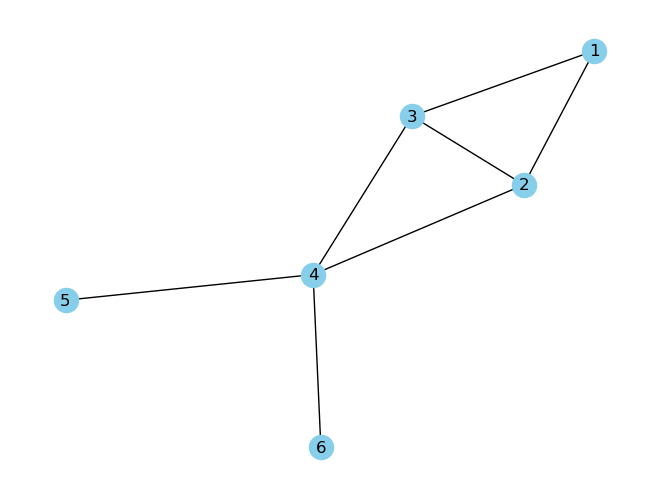

In [4]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
# plt.savefig("plots/graph_n6.pdf")

In [5]:
# obtain true solution to L1-regularized optimization problem
x_opt_star, f_star = obtain_opt_prob_solution(problem_spec, problem_data, network_data)

In [6]:
f_cvx, x_cvx = cvx_compressed_sensing(problem_spec, problem_data)
print(f_star, f_cvx)
f_star, x_opt_star = f_cvx, x_cvx
print(f"{f_star=}, {np.linalg.norm(x_cvx)=}")

0.48149727611721793 0.481497276117218
f_star=0.481497276117218, np.linalg.norm(x_cvx)=2.6729841275541717


In [7]:
rho = problem_data['rho']
A = problem_data['A']
b = problem_data['b']
 
vector_size = problem_spec['vector_size']
n_sensor = problem_spec['n_sensor']
n_sensor_per_node = problem_spec['n_sensor_per_node']
n_node = problem_spec['n_node']

prox_operators = []
fi_operators = []
b_stack = np.reshape(np.repeat(b, n_node), (n_sensor, n_node))
for jj in range(n_node):
    Aj = A[jj*n_sensor_per_node : (jj+1)*n_sensor_per_node]
    bj = b[jj*n_sensor_per_node : (jj+1)*n_sensor_per_node]
    prox_operators += [lambda z, alpha, Aj=Aj, bj=bj:  cvx_prox_fj_hj(z, alpha, rho, Aj, bj, vector_size)]
    fi_operators += [lambda x_kj, Aj=Aj, bj=bj: 1/2 * np.sum((Aj @ x_kj - bj)**2) + rho * np.sum(np.abs(x_kj))]

In [8]:
R = 10
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.04312681633959755, err_opt_reldiff[-1]=0.9657159665926579
ii=200, f_reldiff[-1]=6.66952748213258e-06, err_opt_reldiff[-1]=0.005937890387874682
ii=400, f_reldiff[-1]=3.548084717614645e-08, err_opt_reldiff[-1]=6.473993143349727e-05
ii=600, f_reldiff[-1]=7.961366728807804e-10, err_opt_reldiff[-1]=7.159166069198007e-07
ii=800, f_reldiff[-1]=5.471597386137916e-13, err_opt_reldiff[-1]=7.79199381358644e-09
ii=999, f_reldiff[-1]=5.649141844095194e-15, err_opt_reldiff[-1]=8.734502073585578e-11


In [9]:
params={"R":18, "Inductance":10, "h":1.1054814693822324}
ciradmm_err_opt_star, ciradmm_err_opt_reldiff, ciradmm_const_vio, ciradmm_f_reldiff = co.dadmm("cir_dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.09014586100071627, err_opt_reldiff[-1]=0.96488904706484
ii=200, f_reldiff[-1]=2.3282506815751837e-08, err_opt_reldiff[-1]=0.0001699898758425941
ii=400, f_reldiff[-1]=4.411172759974904e-12, err_opt_reldiff[-1]=4.9035373877972406e-08
ii=600, f_reldiff[-1]=1.614040526884341e-15, err_opt_reldiff[-1]=1.5475037968458792e-11
ii=800, f_reldiff[-1]=1.1528860906316723e-16, err_opt_reldiff[-1]=1.0719393672921631e-14
ii=999, f_reldiff[-1]=0.0, err_opt_reldiff[-1]=1.1896984361540179e-14


In [10]:
# apply PG-EXTRA 
pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = pg_extra_compressed_sensing(None, problem_spec, problem_data, network_data, x_cvx, f_star,)

In [11]:
fname = "n6_circuit_dadmm"

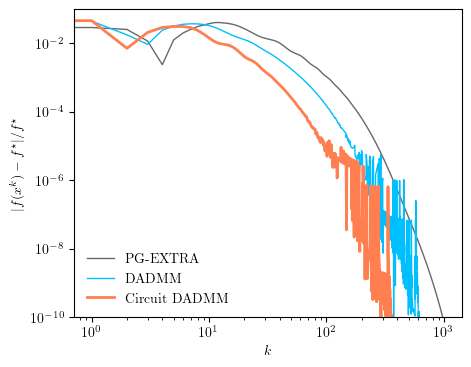

In [14]:
co.plot_methods([pg_f_reldiff, admm_f_reldiff, ciradmm_f_reldiff],
                ['PG-EXTRA', 'DADMM','Circuit DADMM'], 1e-10, 1e-1, fname)